# Figuring out how to use Wildtypes
Attempting to use https://www.kaggle.com/code/vslaykovsky/14656-unique-mutations-voxel-features-pdbs to improve HoltryNet using https://www.kaggle.com/code/vslaykovsky/nesp-thermonet-v2 as a template

In [1]:
import multiprocessing
import os

import Levenshtein
import numpy as np
# from plotly.offline import init_notebook_mode
# from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm

# init_notebook_mode(connected=True)
import glob
from scipy.stats import spearmanr
from pprint import pprint

# import plotly.express as px
import torch
import torch.nn as nn
import pandas as pd
from scipy.stats import rankdata
# import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# from collections import defaultdict
import copy
# from torch.optim import AdamW

MULTIPROCESSING = False
BOXSIZE = 16
VOXELSIZE = 1
N_FOLDS = 10
MODELS_PATH = 'models'
DEBUG = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DESTABILIZING_MUTATIONS_ONLY = True
AUGMENT_DESTABILIZING_MUTATIONS = False
EARLY_STOPPING_PATIENCE = 30
IS_DDG_TARGET = True
WITH_PUCCI_SOURCE = True
WITH_KAGGLE_DDG_SOURCE = True

# switchers
TRAIN = True
WANDB_TRAIN_PROJECT = 'ThermoNetV2-train'
WANDB_TRAIN_NAME = 'thermonetv2-7633-v2'

OPTUNA = False
OPTUNA_WANDB_PROJECT = "ThermoNetV2-Optuna"
OPTUNA_TRIALS = 400

WANDB_SWEEP = False
WANDB_SWEEP_PROJECT = 'ThermoNetV2-sweep'

SUBMISSION = True


DEFAULT_PARAMS = {
    'SiLU': False,
    'diff_features': True,
    'LayerNorm': False,
    'GroupKFold': False,  # only use for hyperopt
    'epochs': 30,
    'AdamW': False,
}





BEST_PARAMS = {**DEFAULT_PARAMS, **{'AdamW': True,
 'C_dt_loss': 0.01,
 'OneCycleLR': False,
 'batch_size': 256,
 'AdamW_decay': 1.3994535042337082,
 'dropout_rate': 0.06297340526648805,
 'learning_rate': 0.00020503764745082723,
 'conv_layer_num': 5,
 'dropout_rate_dt': 0.3153179929570238,
 'dense_layer_size': 74.1731281147114}}



WILDTYPE_PDB = '../data/kaggle/wildtype_structure_prediction_af2.pdb'
PDB_PATH = '../data/thermonet-wildtype-relaxed'
TRAIN_FEATURES_PATH = '../data/thermonet-features/Q3214.npy'
TEST_CSV = '../data/kaggle/test.csv'
TEST_FEATURES_PATH = '../data/thermonet-features/nesp_features.npy'
PUBLIC_SUBMISSIONS=[
    '../submissions/rmsd-from-molecular-dynamics/submission_rmsd.csv',     # LB: 0.507
    '../submissions/plldt-ddg-demask-sasa/deepddg-ddg.csv',                # LB: 0.451
    '../submissions/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv',  # 0.451
    '../submissions/nesp-alphafold-getarea-exploration/submission.csv',                   # 0.407
]    
TRAIN_FEATURES_DIR = '../data/nesp-9936-unique-mutations-voxel-features'

In [2]:
def load_data():
    print("1. Loading csv datasets")
    df = pd.read_csv(f'{TRAIN_FEATURES_DIR}/dataset.csv')
    df.source = df.source.apply(eval)
    print(f'Total unique mutations: {len(df)}')

    df['features'] = df.apply(lambda r: f'{TRAIN_FEATURES_DIR}/features/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}.npy', axis=1)
    df = df[df.features.apply(lambda v: os.path.exists(v))]

    print(f'Total mutations with features: {len(df)}')

    if not WITH_PUCCI_SOURCE:
        df = df[df.source.apply(lambda v: v != ['pucci-proteins-appendixtable1.xlsx'])]

    if not WITH_KAGGLE_DDG_SOURCE:
        df = df[df.source.apply(lambda v: v != ['ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'])]

    print(f'Total mutations after filtering: {len(df)}')

    df.features = [np.load(f) for f in tqdm(df.features, desc="2. Loading features")]


    df_train = df

    if DESTABILIZING_MUTATIONS_ONLY:
        print('Keeping destabilizing mutations only')
        df_train = df_train[((df_train.ddG < 0)) & ((df_train.dT < 0) | df_train.dT.isna())].reset_index(drop=True).copy() # best for ddG
    elif AUGMENT_DESTABILIZING_MUTATIONS:
        print('Augmenting destabilizing mutations')
        df_pos = df_train[df_train.ddG > 0].copy()
        df_neg = df_train[df_train.ddG < 0]
        print(df_pos.shape, df_neg.shape)
        df_pos.features = df_pos.features.apply(lambda f: np.concatenate([f[7:], f[:7]], axis=0))
        df_pos.ddG = -df_pos.ddG
        df_pos.dT = -df_pos.dT
        df_train = pd.concat([df_pos, df_neg], axis=0).sample(frac=1.).reset_index(drop=True)        
    return df_train

try:
    df_train = load_data()
    df_train
except FileNotFoundError as error:
    print(error)
    print("You need to follow the instructions in ../data/README.md and download the remaining .npy files")

1. Loading csv datasets
Total unique mutations: 14656
Total mutations with features: 12167
Total mutations after filtering: 12167


2. Loading features:   0%|          | 0/12167 [00:00<?, ?it/s]

Keeping destabilizing mutations only


,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain,features
0,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[1.00000000e+00 1.83487193e-01 3.07613411e-...
1,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,E,25,25,A,-0.050000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[3.38143335e-06 3.03279778e-05 3.04589878e-...
2,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,23,23,A,-0.763333,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.00000000e+00 0.00000000e+00 0.00000000e+...
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,39,39,A,-0.726667,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.0076158 0.09321734 0.13197631 0.0698161...
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,47,47,A,-0.636429,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...,...,...,...,...,...,...,...,...,...,...,...,...
7628,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,382,269,S,-17.400000,-5.2,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[0.00544725 0.06888345 0.3927299 0.1319893...
7629,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-1.600000,-0.4,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[6.02426507e-04 2.46603597e-03 4.25419226e-...
7630,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,244,131,R,-1.330000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[3.29420297e-02 1.07765760e-01 2.73649860e-...
7631,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[2.24163487e-03 1.26180000e-02 7.25209257e-...


In [3]:
class HoltryNet3d(nn.Module):
    def __init__(self, params):
        super().__init__()

        dropout_rate = params['dropout_rate']
        dropout_rate_dt = params['dropout_rate_dt']
        dense_layer_size = int(params['dense_layer_size'])

        self.params = params

        self.model = nn.Sequential(
            nn.Sequential(
                nn.Conv3d(14, 16, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(16),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv3d(16, 24, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(24),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv3d(24, 32, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(32),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv3d(32, 48, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(48),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv3d(48, 78, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(78),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv3d(78, 128, kernel_size=(3, 3, 3)),
                nn.BatchNorm3d(128),
                nn.ReLU()
            ),
            nn.MaxPool3d(kernel_size=(2,2,2)),
            nn.Flatten()
        )

        self.ddG = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=1024, out_features=dense_layer_size),
            nn.BatchNorm1d(dense_layer_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=dense_layer_size, out_features=1)
        )
        self.dT = nn.Sequential(
            nn.Dropout(p=dropout_rate_dt),
            nn.Linear(in_features=1024, out_features=dense_layer_size),
            nn.BatchNorm1d(dense_layer_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_dt),
            nn.Linear(in_features=dense_layer_size, out_features=1)
        )


    def forward(self, x):
        if self.params['diff_features']:
            x[:, 7:, ...] -= x[:, :7, ...]
        x = self.model(x)
        ddg = self.ddG(x)
        dt = self.dT(x)
        return ddg.squeeze(), dt.squeeze()

        
params = copy.copy(BEST_PARAMS)
params['diff_features'] = False
model = HoltryNet3d(params)
print([out.shape for out in model.forward(torch.randn((2, 14, 16, 16, 16)))])
print(model)
model = model.to(DEVICE)

[torch.Size([2]), torch.Size([2])]
HoltryNet3d(
  (model): Sequential(
    (0): Sequential(
      (0): Conv3d(14, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(16, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv3d(24, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv3d(48, 78, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(78, ep

# Dataset

In [4]:
class HoltryNet3dDataset(Dataset):
    def __init__(self, df=None, features=None):
        self.df = df
        self.features = features

    def __getitem__(self, item):
        if self.df is not None:
            r = self.df.iloc[item]
            if 'ddG' in self.df.columns:
                return torch.as_tensor(r.features, dtype=torch.float), torch.tensor(r.ddG, dtype=torch.float), torch.tensor(r.dT, dtype=torch.float)
            else:
                return torch.as_tensor(r.features, dtype=torch.float)
        else:
            return torch.as_tensor(self.features[item], dtype=torch.float)

    def __len__(self):
        return len(self.df) if self.df is not None else len(self.features)
ds = HoltryNet3dDataset(df=df_train)
feat_tensor = torch.empty(0)
dgg_tensor = torch.empty(0)
dt_tensor = torch.empty(0)
for feat, ddG, dT in iter(DataLoader(ds, batch_size=BEST_PARAMS['batch_size'])):
    feat_tensor = torch.cat((feat_tensor, feat))
    dgg_tensor = torch.cat((dgg_tensor, ddG))
    dt_tensor = torch.cat((dt_tensor, dT))
print(feat_tensor.shape, dgg_tensor.shape, dt_tensor.shape)

torch.Size([7633, 14, 16, 16, 16]) torch.Size([7633]) torch.Size([7633])


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

X = feat_tensor.numpy()
y = tf.stack([dgg_tensor, dt_tensor], axis=1).numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Loading

In [6]:
from torch.utils.data import TensorDataset, DataLoader

trainset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))

#TODO: revise batch_size
trainloader = DataLoader(trainset, batch_size=BEST_PARAMS['batch_size'], shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=BEST_PARAMS['batch_size'], shuffle=True, num_workers=2)

In [7]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Defining the Train Functions

In [9]:
%%time
best_val_loss = 100000
best_val_model = None
MAX_EPOCH = DEFAULT_PARAMS["epochs"]
loss_record = {'train': [], 'dev': []} # added
C_dt_loss = 0.01
for epoch in range(MAX_EPOCH):  
    model.train()
    running_train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # print(labels)
        ddg = labels[:, 0]
        dt = labels[:, 1]

        optimizer.zero_grad()
        ddg_pred, dt_pred = model(inputs)
        
        loss = None
        any_ddg = ~torch.isnan(ddg)
        if torch.any(any_ddg):
            loss = criterion(ddg[any_ddg], ddg_pred[any_ddg])
        any_dt = ~torch.isnan(dt)
        if torch.any(any_dt):
            dt_loss = criterion(dt[any_dt], dt_pred[any_dt])
            if loss is None:
                loss = dt_loss * C_dt_loss
            else:
                loss += dt_loss * C_dt_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_train_loss += loss.item()
    loss_record['train'].append(running_train_loss/len(trainset))
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs,labels in valloader:
            ddg = labels[:, 0]
            dt = labels[:, 1]
            ddg_pred, dt_pred = model(inputs.cuda())
            ddg_pred, dt_pred = ddg_pred.cpu(), dt_pred.cpu()
            ddg_pred, dt_pred = ddg_pred.detach(), dt_pred.detach()
            not_nan_ddg = ~torch.isnan(ddg)
            ddg_loss = criterion(ddg[not_nan_ddg], ddg_pred[not_nan_ddg])

            not_nan_dt = ~torch.isnan(dt)
            dt_loss = criterion(dt[not_nan_dt], dt_pred[not_nan_dt])

            loss = torch.stack([ddg_loss, dt_loss * C_dt_loss])
            loss = loss[~torch.isnan(loss)].sum()
            running_val_loss += loss.item()
    loss_record['dev'].append(running_val_loss/len(valset))
    print("Epoch [{:>2} / {}]: Train loss = {:<25} Val Loss = {:<25}".format(epoch+1, MAX_EPOCH, running_train_loss/len(trainset), running_val_loss/len(valset)))
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_val_model = copy.deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')

Epoch [ 1 / 30]: Train loss = 0.022135798828819716      Val Loss = 0.033882948332700995     
Epoch [ 2 / 30]: Train loss = 0.018686217087196828      Val Loss = 0.023869334285213966     
Epoch [ 3 / 30]: Train loss = 0.01613293961544643       Val Loss = 0.01898605712660794      
Epoch [ 4 / 30]: Train loss = 0.014079038135504825      Val Loss = 0.016875055621633675     
Epoch [ 5 / 30]: Train loss = 0.012261084326360798      Val Loss = 0.0162427072518779       
Epoch [ 6 / 30]: Train loss = 0.010875660319660986      Val Loss = 0.018697694929581336     
Epoch [ 7 / 30]: Train loss = 0.009937597636976596      Val Loss = 0.016585935387801874     
Epoch [ 8 / 30]: Train loss = 0.009045434005917232      Val Loss = 0.016384282920902354     
Epoch [ 9 / 30]: Train loss = 0.008324597590952828      Val Loss = 0.01588382171351065      
Epoch [10 / 30]: Train loss = 0.00772445689175428       Val Loss = 0.015407229375433281     
Epoch [11 / 30]: Train loss = 0.007225737468633268      Val Loss = 0.0

# Learning Curve

In [10]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [11]:
def plot_learning_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = range(len(record['train']))
    x_2 = range(len(record['dev']))
    figure(figsize=(6, 4))
    plt.plot(x_1, record['train'], c='tab:red', label='train')
    plt.plot(x_2, record['dev'], c='tab:cyan', label='dev')
    
    # TODO: feel free to change this range to see the learning curve better
    y_min = min(min(record['train']), min(record['dev']))
    y_max = max(max(record['train']), max(record['dev']))
    plt.ylim(max(.95*y_min-0.01, 0), 1.05*y_max+0.01)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

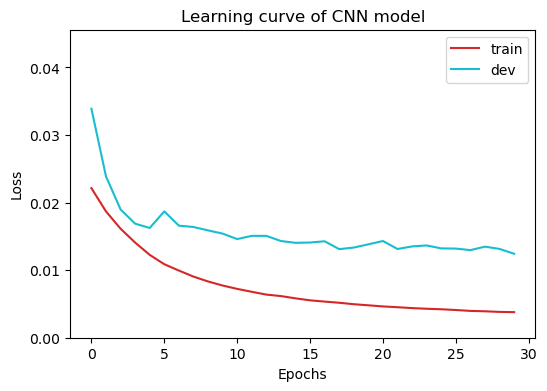

In [12]:
plot_learning_curve(loss_record, title="CNN model")

# Model Evaluation and Prediction

In [13]:
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df

df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
display(df_test)

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [14]:
test_features = np.load(TEST_FEATURES_PATH)
testloader = torch.utils.data.DataLoader(test_features, shuffle=False, num_workers=2)

In [15]:
%%time
preds = []
model.load_state_dict(best_val_model)
model.eval()
with torch.no_grad():
    for inputs in testloader:
        inputs=inputs.float()
        ddg_pred, dt_pred = model(inputs.cuda())
        # only use ddg_pred because it is the main target, whereas dt_pred is the auxilary target
        preds.append(torch.Tensor(ddg_pred.detach().cpu()))
preds = torch.stack(preds).numpy()

Wall time: 14.5 s


In [16]:
# replacement mutations
df_test.loc[df_test.op == 'replace', 'ddg'] = preds
# deletion mutations
df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
# no mutations
df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  
df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('pred3d.csv', index=False)

In [19]:
def make_prediction(preds, file):
    print(f'Saving results to {file}')
    submission = pd.read_csv("../data/kaggle/sample_submission.csv")
    submission["tm"] = preds
    submission.to_csv(file, index=False)

In [23]:
from scipy.stats import rankdata

def ranked(f):
    return rankdata(pd.read_csv(f).tm)

# KaggleScore, DataSource
DataSets = [
    [0.7, '../submissions/rmsd-from-molecular-dynamics/submission_rmsd.csv'],
    [0.1, 'pred_v2.csv'],
    [0.3, '../submissions/plldt-ddg-demask-sasa/deepddg-ddg.csv'],
    [0.3, '../submissions/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv'],
    [0.3, '../submissions/nesp-alphafold-getarea-exploration/submission.csv'],
    [0.3, '../submissions/thermonet-v2/submission.csv'],
    [0.7, '../submissions/nesp-relaxed-rosetta-scores/submission_rosetta_scores.csv'],
]
pred = 0
# weighting each submission by its kaggle score
for i in range(len(DataSets)):
    pred += DataSets[i][0] * ranked(DataSets[i][1])

make_prediction(pred, "ensemble_submission.csv")
!head ensemble_submission.csv

Saving results to ensemble_submission.csv


'head' is not recognized as an internal or external command,
operable program or batch file.
